In [24]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
# https://keras.io/layers/convolutional/
# 2D卷积合适一个矩阵
# RNN是在语音和文本中使用

digit = load_digits()

data_x = digit.data
data_y = digit.target


x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)


In [25]:
import theano

In [26]:
# 查看一下
x_train.shape # 64 -> 8 * 8

(1437, 64)

In [27]:
# 导入想换类库
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K # keras 的backend 既可以是tensorflow也可以是别的东西

In [28]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 8, 8

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0],1,img_rows,img_cols)
    x_test = x_test.reshape(x_test.shape[0],1,img_rows,img_cols)
    input_shape = (1,img_rows,img_cols) # 1 就是通道数， 3 就是RGB， 1 = 黑白的/灰度图
    print (input_shape)
else:
    x_train = x_train.reshape(x_train.shape[0],img_rows,img_cols,1)
    x_test = x_test.reshape(x_test.shape[0],img_rows,img_cols,1)
    input_shape = (img_rows,img_cols,1)
    print (input_shape)

(8, 8, 1)


In [29]:
# 0~1 float

x_train = x_train.astype("float32")
x_test  = x_test.astype("float32")
x_train /= 255
x_test  /=255 # 归一化，一般要给神经网络数据时 都要归一化 0-1之间或0-10之间

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1437, 8, 8, 1)
1437 train samples
360 test samples


In [30]:

y_train = keras.utils.to_categorical(y_train,num_classes) # one-hot vector , 因为softmax要用
y_test = keras.utils.to_categorical(y_test,num_classes)

model =Sequential() # 初始化序列化模型， 因为神经网络都是一层一层的都是序列化的
#model.add(Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=input_shape)) #32C3

#model.add(Conv2D(64, kernel_size=(3,3), activation='relu')) #64C3

#model.add(MaxPooling2D(pool_size=(2,2))) #MP2

model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape))
convout1 = Activation('relu')
model.add(convout1) #32C3

model.add(Conv2D(64, kernel_size=(3,3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu')) # Dense前都要接Flatten , 6C5-MP2-16C5-MP2-120C1    (FLATTEN)   -84N-10N

model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [31]:
batch_size = 128
epochs = 1
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 1437 samples, validate on 360 samples
Epoch 1/1
 128/1437 [=>............................] - ETA: 321s - loss: 2.3034 - acc: 0.0859

KeyboardInterrupt: 

# 1. Kernel shape

In [32]:
# visulise weights
import numpy as np
W = model.layers[0].kernel.get_value(borrow=True)
W = np.squeeze(W)
print ("W shape : " , W.shape)

W shape :  (3, 3, 32)


In [48]:
import numpy as np

y_pred = np.argmax(model.predict(x_train),axis=1) # 把one Hot vector 转换回到数字

In [33]:
W[:,:,0] # 第一个卷积核的所有内容


array([[ 0.04594247,  0.03799061, -0.1205595 ],
       [ 0.11602765, -0.08880974,  0.04387789],
       [-0.06434739,  0.0857822 ,  0.09397142]], dtype=float32)

# 2. visualize the convolution kernel

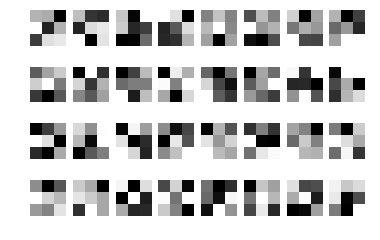

In [34]:
# 画图 画出卷积核 kernel
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(32):
    sub = plt.subplot(4,8,i+1) # 4行8列 第 1 2 3 福图
    plt.axis('off')
    sub.imshow(W[:,:,i], cmap=plt.cm.gray)

# 3. print the shape after image is convolved by kernel

In [35]:
# 画出卷积后的结果 = 输出 visualization
import theano

convout1_f = theano.function(model.inputs,[convout1.output])
C1 = convout1_f([x_train[0]])
C1 = np.squeeze(C1)
print("C1 Shape : ", C1.shape)

C1 Shape :  (6, 6, 32)


# 4. visulize image after convolution by the kernel

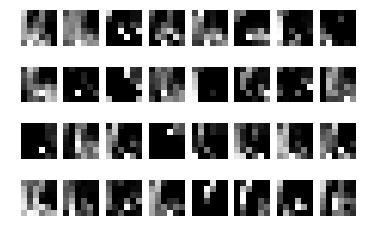

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(32):
    sub = plt.subplot(4,8,i+1)
    plt.axis('off')
    sub.imshow(C1[:,:,i], cmap=plt.cm.gray)